> __Purpose:__ Implement a linkage attack, an initial and final one, on the newly saved data from the latest sims. Significant alterations were required to extract the data from the latest sims save files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
import os
import h5py
import copy
import statistics
import seaborn as sns
import re

from sklearn.svm import SVC

from utils import *

random.seed(a=1)

In [2]:
title_fontsize = 18
labels_fontsize = 18
ticks_fontsize = 18
global_fontsize = 18  # Shared default fontsize...

# Customizing fonts globally (optional, can be changed)
plt.rcParams.update({
    'font.family': 'sans-serif',  # Choose a serif font
    'font.serif': ['Arial'],  # Set to Times New Roman (if available)
    'font.size': labels_fontsize,  # Adjust default font size
    'axes.titlesize': title_fontsize,  # Title font size
    'axes.labelsize': labels_fontsize,  # Label font size
    'legend.fontsize': 12,  # Legend font size
})

## Load Data

In [3]:
NUM_CLIENTS = 14
NUM_FOLDS = 7

results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\FinalSimRes'
base_path = results_path + current_directory

# CROSS
cpfa_model_dict = load_model_logs(base_path+r'\10-05_14-32_PFAFO_Cross5', 'GDLS_PFAFO_KFold')
cfa_model_dict = load_model_logs(base_path+r'\10-05_14-48_FEDAVG_Cross5', 'GDLS_FEDAVG_KFold')
cnofl_model_dict = load_model_logs(base_path+r'\10-05_14-23_NOFL_Cross', 'FULLSCIPYMIN_NOFL_KFold')
# INTRA
ipfa_model_dict = load_model_logs(base_path+r'\10-05_14-13_PFAFO_Intra5', 'GDLS_PFAFO_KFold')
ifa_model_dict = load_model_logs(base_path+r'\10-05_13-46_FEDAVG_Intra5', 'GDLS_FEDAVG_KFold')
inofl_model_dict = load_model_logs(base_path+r'\10-05_13-44_NOFL_Intra', 'FULLSCIPYMIN_NOFL_KFold')


In [4]:
print(len(cfa_model_dict.keys()))
print(np.sum([1 for key in cfa_model_dict.keys() if 'global' in key]))


105
7


In [5]:
print(len(cnofl_model_dict.keys()))
print(np.sum([1 for key in cnofl_model_dict.keys() if 'global' in key]))

98
0.0


# Adversarial Modeling

In [6]:
my_subjects_lst = ['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13']

In [7]:
augmented_subj_lst = list(my_subjects_lst) + [f'{subj}G' for subj in my_subjects_lst]
augmented_subj_lst

['S0',
 'S1',
 'S2',
 'S3',
 'S4',
 'S5',
 'S6',
 'S7',
 'S8',
 'S9',
 'S10',
 'S11',
 'S12',
 'S13',
 'S0G',
 'S1G',
 'S2G',
 'S3G',
 'S4G',
 'S5G',
 'S6G',
 'S7G',
 'S8G',
 'S9G',
 'S10G',
 'S11G',
 'S12G',
 'S13G']

In [8]:
ordered_conds_lst = [inofl_model_dict, ipfa_model_dict, ifa_model_dict, cnofl_model_dict, cpfa_model_dict, cfa_model_dict]
num_conds = len(ordered_conds_lst)
num_us_updates = 14
num_global_duplicates = 13
svc_acc_by_client_dicts_lst = [{subj_str: [] for subj_str in augmented_subj_lst} for _ in range(num_conds)]

for cond_idx, cond_dict in enumerate(ordered_conds_lst):
    flattened_input_df, num_updates, global_flattened_input_df, max_update = create_linkage_attack_df(cpfa_model_dict)
    fold_df = flattened_input_df[flattened_input_df['Fold']==0]

    if cond_idx in [0, 3]:
        # Local models
        ## Generate 14 equally spaced indexes from 0 to 95
        equally_spaced_updates = np.linspace(0, num_updates - 1, num_us_updates, dtype=int).tolist()
        updates_lst = equally_spaced_updates[-4:]
    else:
        # FL MODELS
        ## Local models
        ### Generate 14 equally spaced indexes from 0 to 95
        equally_spaced_updates = np.linspace(0, num_updates - 1, num_us_updates, dtype=int).tolist()
        updates_lst = equally_spaced_updates[-4:]

        ## Global models
        global_equally_spaced_updates = np.linspace(0, max_update - 1, num_us_updates, dtype=int).tolist()
        global_updates_lst = global_equally_spaced_updates[-4:]
        global_fold_df = global_flattened_input_df[global_flattened_input_df['Fold']==0]
        final_n_global_models_df = global_fold_df[global_fold_df["Update Number"].isin(global_updates_lst)]

        # Generate duplicates with updated subject IDs
        dfs = [final_n_global_models_df]  # Start with the original DataFrame in the list
        for i in range(1, num_global_duplicates + 1):  # Starts at 1 since S0 is the only subject in the df at start!
            df_copy = final_n_global_models_df.copy()
            df_copy['Subject'] = f'S{i}'
            dfs.append(df_copy)
        final_n_global_models_df = pd.concat(dfs, ignore_index=True)
    
    final_n_models_df = fold_df[fold_df["Update Number"].isin(updates_lst)]
        
    for idx in range(100):
        # Do the train test split
        test_update_idx = random.choice(updates_lst)
        # Set the train indices
        train_idxs_lst = [num for num in updates_lst if num != test_update_idx]
        # Slice the df to create the train and test sets
        test_df = final_n_models_df[final_n_models_df['Update Number']==test_update_idx]
        train_df = final_n_models_df[final_n_models_df['Update Number'].isin(train_idxs_lst)]
    
        X_train = np.array([row.flatten() for row in train_df.iloc[:, 3:].values])
        y_train = np.array(train_df['Subject'])
        X_test = np.array([row.flatten() for row in test_df.iloc[:, 3:].values])
        y_test = np.array(test_df['Subject'])
    
        # Train the model
        svc = SVC(kernel='linear')
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        # Save the accuracy BY CLIENT!
        for sidx, subject_ID_num in enumerate(y_test):
            svc_acc_by_client_dicts_lst[cond_idx][f"{subject_ID_num}"].append(subject_ID_num==y_pred[sidx])

        if cond_idx not in [0, 3]:
            global_test_update_idx = random.choice(global_updates_lst)
            global_train_idxs_lst = [num for num in global_updates_lst if num != global_test_update_idx]
            global_test_df = final_n_global_models_df[final_n_global_models_df['Update Number']==global_test_update_idx]
            global_train_df = final_n_global_models_df[final_n_global_models_df['Update Number'].isin(global_train_idxs_lst)]
            Xg_train = np.array([row.flatten() for row in global_train_df.iloc[:, 3:].values])
            yg_train = np.array(global_train_df['Subject'])
            Xg_test = np.array([row.flatten() for row in global_test_df.iloc[:, 3:].values])
            yg_test = np.array(global_test_df['Subject'])
            global_svc = SVC(kernel='linear')
            global_svc.fit(Xg_train, yg_train)
            yg_pred = global_svc.predict(Xg_test)
            for sidx, subject_ID_num in enumerate(yg_test):
                if subject_ID_num in ["S0", "S1"]:  # These users arent present in fold 0
                    continue
                svc_acc_by_client_dicts_lst[cond_idx][f"{subject_ID_num}G"].append(subject_ID_num==yg_pred[sidx])

num updates = 96; max_update 127; avg_num_updates 90.28571428571429
num updates = 96; max_update 127; avg_num_updates 90.28571428571429
num updates = 96; max_update 127; avg_num_updates 90.28571428571429
num updates = 96; max_update 127; avg_num_updates 90.28571428571429
num updates = 96; max_update 127; avg_num_updates 90.28571428571429
num updates = 96; max_update 127; avg_num_updates 90.28571428571429


In [9]:
# KEEP THIS CELL!

condition_numbers = []
scenarios = []
data_points = []
global_condition_numbers = []
global_scenarios = []
global_data_points = []
for cond_idx, sublst_dict in enumerate(svc_acc_by_client_dicts_lst):
    scatterpoints = []
    global_scatterpoints = []
    scenario = 'Intra-Subject' if cond_idx < 3 else 'Cross-Subject'
    
    for subj_key in sublst_dict.keys():
        if "G" in subj_key and cond_idx not in [0, 3]:
            # If G in key then append to the global log
            raw_cli_score = sublst_dict[subj_key]
            cli_acc = np.mean(raw_cli_score)
            global_scatterpoints.append(cli_acc)
        else:
            # Else append it to the nonglobal log
            ## Non globals will get their own key
            raw_cli_score = sublst_dict[subj_key]
            cli_acc = np.mean(raw_cli_score)
            if len(raw_cli_score)==0:
                if ("G" in subj_key and cond_idx in [0, 3]) or subj_key in ["S0", "S1"]:
                    # S0 and S1 are missing cause of the fold (they were not trained in fold0)
                    # Also fine if globals are missing for the NOFL cases
                    cli_acc = None
                else:
                    raise ValueError("EMPTY")
            scatterpoints.append(cli_acc)
        
    # Append each entry in this list to our columns
    condition_numbers.extend([cond_idx] * len(scatterpoints))
    scenarios.extend([scenario] * len(scatterpoints))
    data_points.extend(scatterpoints)
    if "G" in subj_key and cond_idx not in [0, 3]:
        #print(f"GLOBAL RUNNING: subj_key: {subj_key}, cond_idx: {cond_idx}") # --> Working as expected rn...
        global_condition_numbers.extend([cond_idx] * len(scatterpoints))
        global_scenarios.extend([scenario] * len(scatterpoints))
        global_data_points.extend(global_scatterpoints)
    
def x_pos_map(condition_values_lst):
    mapping = {0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 2}
    return [mapping[val] for val in condition_values_lst]

def algo_map(condition_values_lst):
    mapping = {0: 'Local', 1: 'Per-FedAvg', 2: 'FedAvg', 3: 'Local', 4: 'Per-FedAvg', 5: 'FedAvg'}
    return [mapping[val] for val in condition_values_lst]

privacy_df = pd.DataFrame({
    'Condition_Number': condition_numbers,
    'Algorithm': algo_map(condition_numbers), 
    'x_pos': x_pos_map(condition_numbers),
    'Scenario': scenarios,
    'Privacy_Risk': data_points,
    'Model': ['Local' for _ in range(len(condition_numbers))]
})

global_privacy_df = pd.DataFrame({
    'Condition_Number': global_condition_numbers,
    'Algorithm': algo_map(global_condition_numbers), 
    'x_pos': x_pos_map(global_condition_numbers),
    'Scenario': global_scenarios,
    'Privacy_Risk': global_data_points,
    'Model': ['Global' for _ in range(len(global_condition_numbers))]
})

C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [10]:
#[b1_c0_lri, b1_c2_lsi, b1_c3_st, b1_c4_pri, b1_c5_psi]
cond_labels = ["Local", "Per-FedAvg", "FedAvg", "Local", "Per-FedAvg", "FedAvg"]

# Define the desired order for the box plots
boxplot_order = [0, 1, 2, 3, 4, 5] #['Local Random', 'Local Sims', 'PFA Random', 'PFA Sims', 'None']

## Tracking Performance Error

In [11]:
def load_cfc_logs(cv_results_path, filename, type=None, num_clients=14, num_folds=7, verbose=False):
    extraction_dict = dict()
    for i in range(num_folds):
        h5_path = os.path.join(cv_results_path, filename+f"{i}.h5")
        #print(h5_path)
        
        # Load data from HDF5 file
        with h5py.File(h5_path, 'r') as f:
            #print(f.keys())
            a_group_key = list(f.keys())
            for key in a_group_key:
                #print(key)
        
                if key=="client_global_cost_func_comps_log" or key=="client_local_cost_func_comps_log":
                    client_keys = list(f[key])
                    #print("key {key}; client keys:")
                    #print(client_keys)
                    for ck in client_keys:
                        ed_key = f"{ck}_fold{i}"  # Does this never update from or something...
                        #print(f"Key: {key}, Client: {ck}, Fold: {i}")
        
                        # So this doenst have any knoledge of the fold number???
                        if len(list(f[key][ck]))==0:
                            val = list(f[key][ck])
                            #print(f"{ed_key} SKIPPED!")
                            pass
                        else:
                            #print(f"{ed_key} SUCCESS!")
                            extraction_dict[ed_key] = list(f[key][ck])
                else:
                    pass
    return extraction_dict


In [12]:
results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\FinalSimRes'
base_path = results_path + current_directory

# CROSS
cpfa_cfc_dict = load_cfc_logs(base_path+r'\10-05_14-32_PFAFO_Cross5', 'GDLS_PFAFO_KFold')
cfa_cfc_dict = load_cfc_logs(base_path+r'\10-05_14-48_FEDAVG_Cross5', 'GDLS_FEDAVG_KFold')
cnofl_cfc_dict = load_cfc_logs(base_path+r'\10-05_14-23_NOFL_Cross', 'FULLSCIPYMIN_NOFL_KFold')
# INTRA
ipfa_cfc_dict = load_cfc_logs(base_path+r'\10-05_14-13_PFAFO_Intra5', 'GDLS_PFAFO_KFold')
ifa_cfc_dict = load_cfc_logs(base_path+r'\10-05_13-46_FEDAVG_Intra5', 'GDLS_FEDAVG_KFold')
inofl_cfc_dict = load_cfc_logs(base_path+r'\10-05_13-44_NOFL_Intra', 'FULLSCIPYMIN_NOFL_KFold')


In [13]:
cpfa_cfc_avg_client_dict, cpfa_cfc_avg_global_logs = avg_client_results_across_folds(cpfa_cfc_dict, "PFA")
cfa_cfc_avg_client_dict, cfa_cfc_avg_global_dict = avg_client_results_across_folds(cfa_cfc_dict, "FedAvg")
cnofl_cfc_avg_client_dict, _ = avg_client_results_across_folds(cnofl_cfc_dict, "NOFL")
ipfa_cfc_avg_client_dict, ipfa_cfc_avg_global_dict = avg_client_results_across_folds(ipfa_cfc_dict, "PFA")
ifa_cfc_avg_client_dict, ifa_cfc_avg_global_dict = avg_client_results_across_folds(ifa_cfc_dict, "FedAvg")
inofl_cfc_avg_client_dict, _ = avg_client_results_across_folds(inofl_cfc_dict, "NOFL")
                                

In [14]:
# ORDER MATTERS!!!
## Making it match the order from the first set of graphs
## Code for labels is hardcoded in the figure! So thats why it must match

all_dicts = [inofl_cfc_avg_client_dict, ipfa_cfc_avg_client_dict, ifa_cfc_avg_client_dict, cnofl_cfc_avg_client_dict, cpfa_cfc_avg_client_dict, cfa_cfc_avg_client_dict]
all_trials_lst = [list(my_dict.values()) for my_dict in all_dicts]

global_dicts = [ipfa_cfc_avg_global_dict, ifa_cfc_avg_global_dict, cpfa_cfc_avg_global_logs, cfa_cfc_avg_global_dict]
global_model_data_by_client = [list(my_dict.values()) for my_dict in global_dicts]
global_model_data = [np.mean(list(my_dict.values())) for my_dict in global_dicts]

In [15]:
# Data for intra-subject and cross-subject groups, ordered as Local, PerFedAvg, FedAvg
all_trials_intra = [all_trials_lst[0], all_trials_lst[2], all_trials_lst[1]]
all_trials_cross = [all_trials_lst[3], all_trials_lst[5], all_trials_lst[4]]
all_trials_combined = all_trials_intra + all_trials_cross  # Combine for single boxplot

In [16]:
all_trials_intra_df = pd.DataFrame({
    'Condition_Number': [0, 1, 2],
    'x_pos': [0, 1, 2],
    'Algorithm': ['Local', 'Per-FedAvg', 'FedAvg'], 
    'Scenario': ['Intra']*3,
    'Tracking_Error': all_trials_intra
})

all_trials_cross_df = pd.DataFrame({
    'Condition_Number': [4, 5, 6],
    'x_pos': [0, 1, 2],
    'Algorithm': ['Local', 'Per-FedAvg', 'FedAvg'], 
    'Scenario': ['Cross']*3,
    'Tracking_Error': all_trials_cross
})

# Use explode to unpack each list into separate rows
all_trials_intra_df = all_trials_intra_df.explode('Tracking_Error', ignore_index=True)
all_trials_cross_df = all_trials_cross_df.explode('Tracking_Error', ignore_index=True)


# Primary Outcome Figure 2x2
> Intra-subject Vs Cross-Subject

In [17]:
intra_privacy_df = privacy_df[privacy_df['Scenario']=='Intra-Subject']
cross_privacy_df = privacy_df[privacy_df['Scenario']=='Cross-Subject']

global_intra_privacy_df = global_privacy_df[global_privacy_df['Scenario']=='Intra-Subject']
global_cross_privacy_df = global_privacy_df[global_privacy_df['Scenario']=='Cross-Subject']

In [18]:
full_intra_privacy_df = pd.concat([intra_privacy_df, global_intra_privacy_df]).reset_index(drop=True)
full_cross_privacy_df = pd.concat([cross_privacy_df, global_cross_privacy_df]).reset_index(drop=True)

print(full_intra_privacy_df.shape)
full_intra_privacy_df.head()

(84, 6)


,Condition_Number,Algorithm,x_pos,Scenario,Privacy_Risk,Model
0,0,Local,0,Intra-Subject,NaN,Local
1,0,Local,0,Intra-Subject,NaN,Local
2,0,Local,0,Intra-Subject,0.46,Local
3,0,Local,0,Intra-Subject,0.22,Local
4,0,Local,0,Intra-Subject,0.76,Local


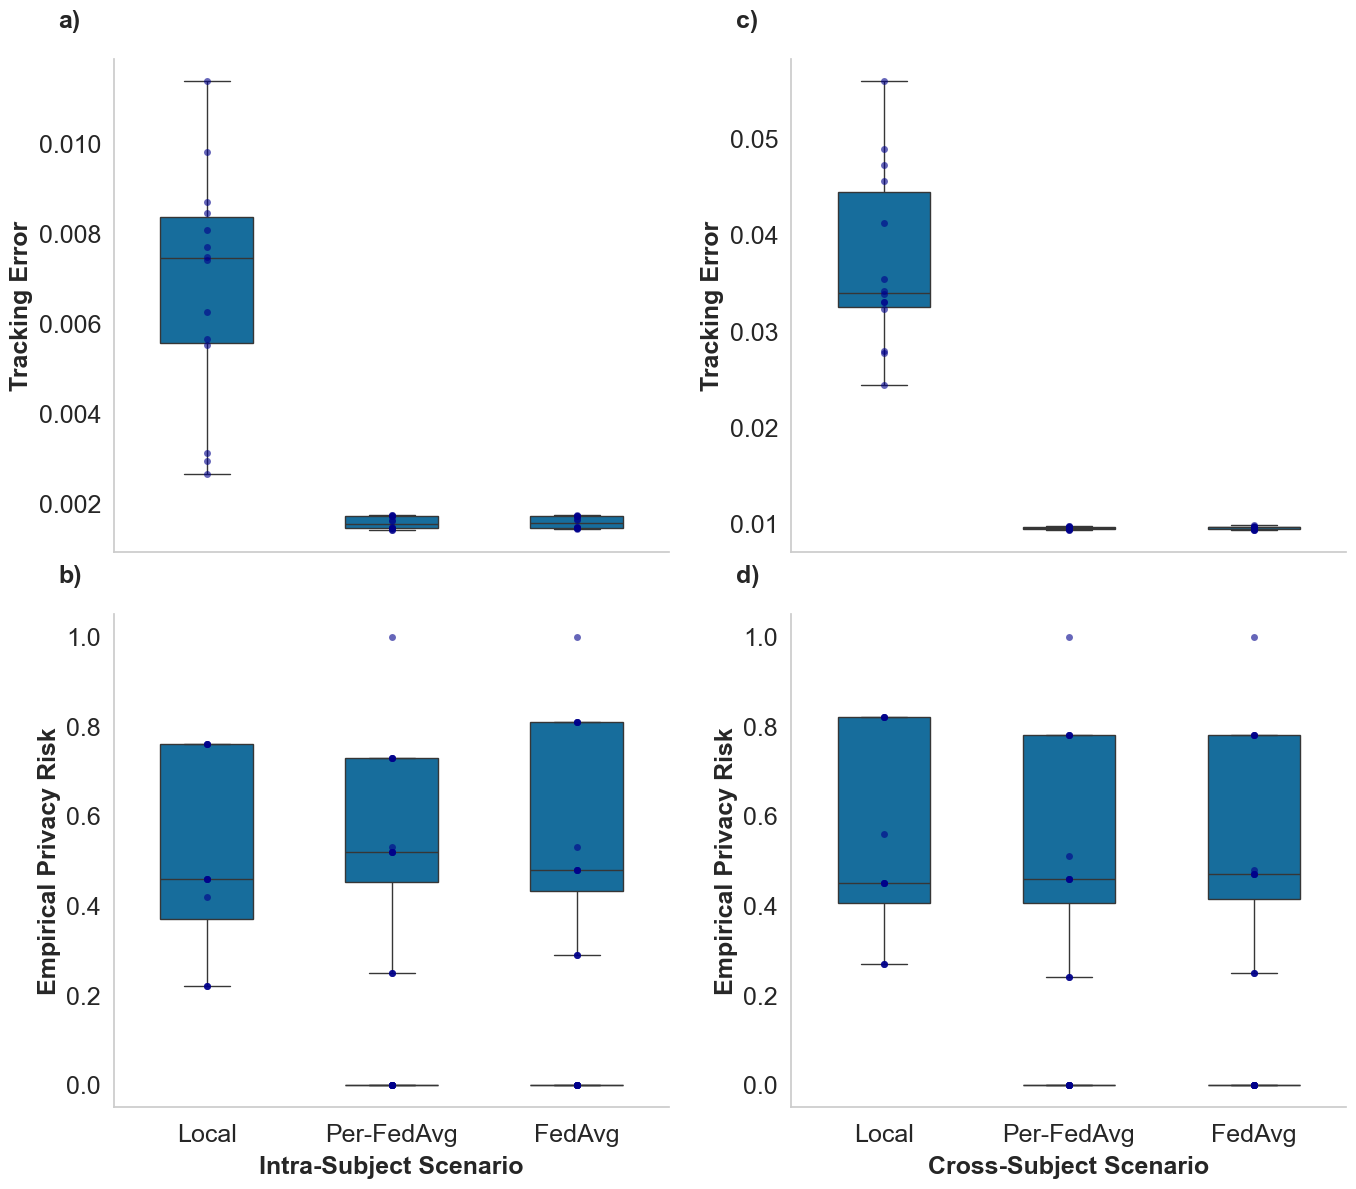

In [19]:
my_palette = 'colorblind'
# Load the palette
my_palette_obj = sns.color_palette(my_palette)
first_color = my_palette_obj[0]
second_color = my_palette_obj[1]
third_color = my_palette_obj[2]
fourth_color = my_palette_obj[3]

# Set up Seaborn style and create the figure with a 2x2 grid of subplots
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(14, 12), sharex=False)

########################################################################################

# Top-left plot (a): Intra-subject Tracking Error
sns.boxplot(x='x_pos', y='Tracking_Error', data=all_trials_intra_df, ax=axs[0, 0], hue='Scenario', palette=my_palette, width=0.5, 
            dodge=False)#, order=boxplot_order)
sns.stripplot(x='x_pos', y='Tracking_Error', data=all_trials_intra_df, ax=axs[0, 0], color='darkblue', alpha=0.6, jitter=0.0)#, order=boxplot_order)
axs[0, 0].set_ylabel("Tracking Error", fontweight='bold', fontsize=global_fontsize)
axs[0, 0].tick_params(axis='y', labelsize=global_fontsize)
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['right'].set_visible(False)
axs[0, 0].grid(False)
axs[0, 0].legend().remove()
axs[0, 0].tick_params(labelbottom=False)
#axs[0, 0].set_xticks([])
axs[0, 0].set_xlabel("")
axs[0, 0].text(-0.1, 1.1, "a)", transform=axs[0, 0].transAxes, fontsize=global_fontsize, fontweight='bold', va='top')

########################################################################################

# Bottom-left plot (b): Intra-subject Privacy Risk
sns.boxplot(data=full_intra_privacy_df, x='x_pos', y='Privacy_Risk', hue='Model', width=0.5,
            ax=axs[1, 0], showfliers=False, dodge=False, palette=my_palette)#, order=[0, 1, 2, 3, 4])
sns.stripplot(x='x_pos', y='Privacy_Risk', data=full_intra_privacy_df, ax=axs[1, 0], color='darkblue', alpha=0.6, jitter=0.0)#, order=boxplot_order)

axs[1, 0].set_ylabel('Empirical Privacy Risk', fontsize=global_fontsize, fontweight='bold')
axs[1, 0].set_xlabel("Intra-Subject Scenario", fontsize=global_fontsize, fontweight='bold', labelpad=35)
axs[1, 0].tick_params(axis='y', labelsize=global_fontsize)
axs[1, 0].tick_params(axis='x', pad=40)  # THESE ARENT EVEN SHOWN RN!
axs[1, 0].set_xticks([])
ylim = axs[1, 0].get_ylim()
y_position = ylim[0] - 0.07 * (ylim[1] - ylim[0])
axs[1, 0].text(0, y_position, 'Local', ha='center', fontsize=global_fontsize)
axs[1, 0].text(1, y_position, 'Per-FedAvg', ha='center', fontsize=global_fontsize)
axs[1, 0].text(2, y_position, 'FedAvg', ha='center', fontsize=global_fontsize)
axs[1, 0].spines['top'].set_visible(False)
axs[1, 0].spines['right'].set_visible(False)
axs[1, 0].grid(False)
#legend = axs[1, 0].legend(loc="lower left")
#legend.set_title("Model Initialization")
#for text in legend.get_texts():
#    text.set_fontsize(global_fontsize)
axs[1, 0].legend().remove()
axs[1, 0].text(-0.1, 1.1, "b)", transform=axs[1, 0].transAxes, fontsize=global_fontsize, fontweight='bold', va='top')

########################################################################################

# Top-right plot (c): Cross-subject Tracking Error
axs[0, 1].text(-0.1, 1.1, "c)", transform=axs[0, 1].transAxes, fontsize=global_fontsize, fontweight='bold', va='top')

sns.boxplot(data=all_trials_cross_df, x='x_pos', y='Tracking_Error', hue='Scenario', width=0.5,
            ax=axs[0, 1], showfliers=False, dodge=False, palette=my_palette)#, order=condition_order)
sns.stripplot(x='x_pos', y='Tracking_Error', data=all_trials_cross_df, ax=axs[0, 1], color='darkblue', alpha=0.6, jitter=0.0)#, order=boxplot_order)

# Customize appearance
axs[0, 1].tick_params(axis='x')#, pad=40)
axs[0, 1].set_ylabel('Tracking Error', fontsize=labels_fontsize, fontweight='bold')
axs[0, 1].set_xlabel('', fontsize=labels_fontsize, fontweight='bold')
axs[0, 1].tick_params(axis='y', labelsize=global_fontsize)
axs[0, 1].set_xticklabels([])  # Remove x tick labels from the bottom plot

# Remove top and right plot borders
axs[0, 1].spines['top'].set_visible(False)
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].grid(False)
axs[0, 1].legend().remove()

########################################################################################

# Bottom-right plot (d): Cross-subject Privacy Risk
axs[1, 1].text(-0.1, 1.1, "d)", transform=axs[1, 1].transAxes, fontsize=global_fontsize, fontweight='bold', va='top')

sns.boxplot(data=full_cross_privacy_df, x='x_pos', y='Privacy_Risk', hue='Model', width=0.5,
            ax=axs[1, 1], showfliers=False, dodge=False, palette=my_palette)#, order=[0, 1, 2, 3, 4])
sns.stripplot(x='x_pos', y='Privacy_Risk', data=full_cross_privacy_df, ax=axs[1, 1], color='darkblue', alpha=0.6, jitter=0.0)#, order=boxplot_order)

axs[1, 1].set_ylabel('Empirical Privacy Risk', fontsize=global_fontsize, fontweight='bold')
axs[1, 1].set_xlabel("Cross-Subject Scenario", fontsize=global_fontsize, fontweight='bold', labelpad=35)
axs[1, 1].tick_params(axis='x', pad=40)  # THESE ARENT EVEN SHOWN RN!
axs[1, 1].tick_params(axis='y', labelsize=global_fontsize)
axs[1, 1].set_xticks([])
ylim = axs[1, 1].get_ylim()
y_position = ylim[0] - 0.07 * (ylim[1] - ylim[0])
axs[1, 1].text(0, y_position, 'Local', ha='center', fontsize=global_fontsize)
axs[1, 1].text(1, y_position, 'Per-FedAvg', ha='center', fontsize=global_fontsize)
axs[1, 1].text(2, y_position, 'FedAvg', ha='center', fontsize=global_fontsize)
axs[1, 1].spines['top'].set_visible(False)
axs[1, 1].spines['right'].set_visible(False)
axs[1, 1].grid(False)
#legend = axs[1, 0].legend(loc="lower left")
#legend.set_title("Model Initialization")
#for text in legend.get_texts():
#    text.set_fontsize(global_fontsize)
axs[1, 1].legend().remove()

########################################################################################

# Adjust the subplot layout
plt.subplots_adjust(wspace=10, hspace=0.1)  # Increase wspace for more space between columns

# Final layout adjustments
plt.tight_layout()
#plt.savefig('Sims_PrimaryOutcome.png', dpi=500, bbox_inches='tight')
plt.show()